# Analysis of scrna-seq _in vitro_ PrE differentation

After looking more into the FACS data, we found out that the gates were set differently. This is a problem as plate full with 2iLIF is basically filled with dead cells. 
Other plates had the gates set correctly.

In [1]:
%matplotlib inline
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# n_blocks = 8
random_seed = 12345
np.random.seed(random_seed)
sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 3

In [2]:
%run ../scripts/helpers.py

## Observed problem

In [3]:
sara = sc.read('../data/processed/sara.RDS.h5ad')

In [4]:
sara.obs.plate_ID = sara.obs.plate_ID.astype('category')

/opt/conda/envs/scanpy-1.5.1/lib/python3.7/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


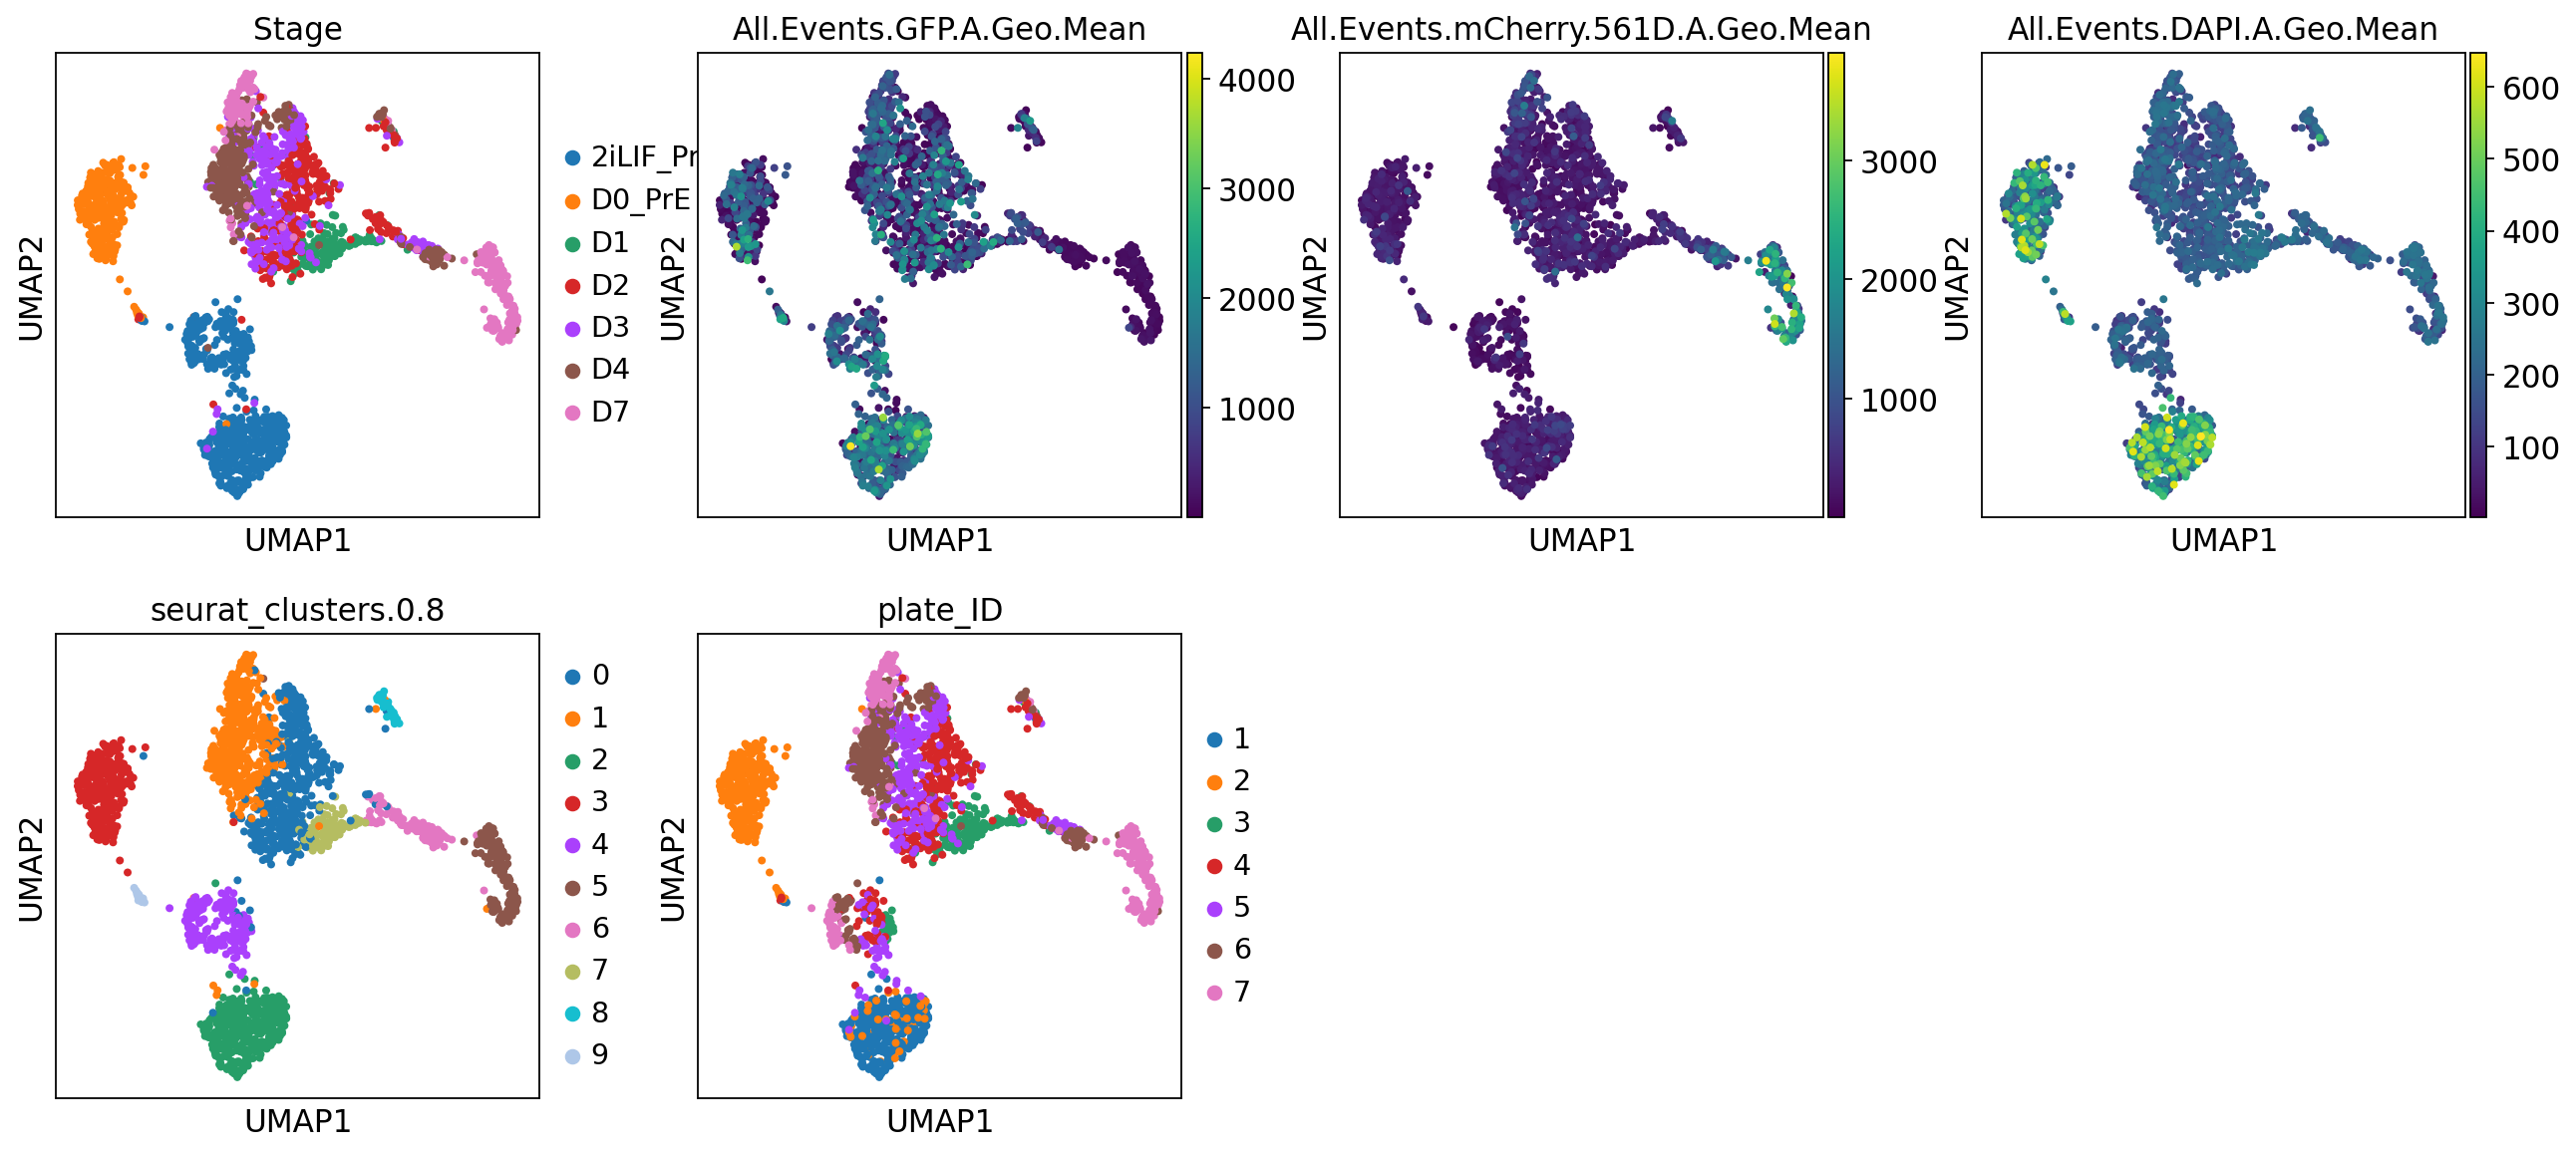

In [5]:
sc.pl.umap(sara, color=['Stage', 'All.Events.GFP.A.Geo.Mean', 'All.Events.mCherry.561D.A.Geo.Mean', 'All.Events.DAPI.A.Geo.Mean', 'seurat_clusters.0.8', 'plate_ID'])

<AxesSubplot:xlabel='All.Events.mCherry.561D.A.Geo.Mean', ylabel='All.Events.GFP.A.Geo.Mean'>

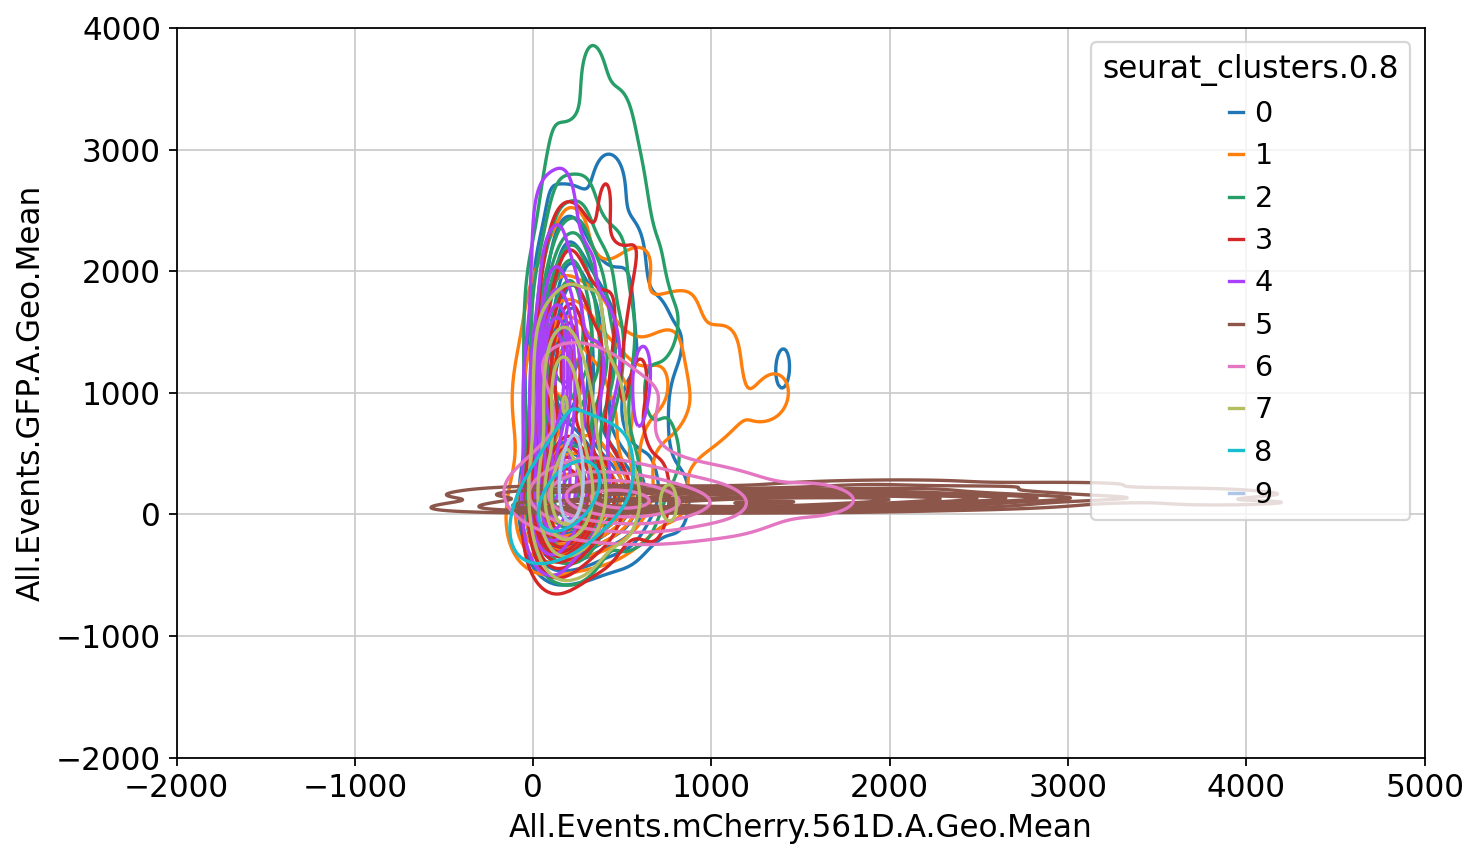

In [6]:
rcParams["figure.figsize"] = 10, 6
plt.xlim(-2_000, 5_000)
plt.ylim(-2_000, 4_000)
sns.kdeplot(x='All.Events.mCherry.561D.A.Geo.Mean', y='All.Events.GFP.A.Geo.Mean', hue='seurat_clusters.0.8', data=sara.obs)

In [7]:
# rcParams["figure.figsize"] = 10, 6
# plt.xlim(-2_000, 5_000)
# plt.ylim(-2_000, 4_000)
# sns.scatterplot(sara.obs['All.Events.mCherry.561D.A.Geo.Mean'], sara.obs['All.Events.GFP.A.Geo.Mean'], hue=sara.obs['seurat_clusters.0.8'])

In [8]:
# rcParams["figure.figsize"] = 10, 6
# sub = sara[sara.obs['seurat_clusters.0.8'].isin(['0', '1'])]
# plt.xlim(-2_000, 5_000)
# plt.ylim(-2_000, 4_000)
# sns.kdeplot(sub.obs['All.Events.mCherry.561D.A.Geo.Mean'], sub.obs['All.Events.GFP.A.Geo.Mean'], hue=sub.obs['seurat_clusters.0.8'])

In [9]:
# rcParams["figure.figsize"] = 10, 6
# sub = sara[sara.obs['seurat_clusters.0.8'].isin(['7', '6', '5'])]
# plt.xlim(-2_000, 5_000)
# plt.ylim(-2_000, 4_000)
# sns.kdeplot(sub.obs['All.Events.mCherry.561D.A.Geo.Mean'], sub.obs['All.Events.GFP.A.Geo.Mean'], hue=sub.obs['seurat_clusters.0.8'])

In [10]:
# rcParams["figure.figsize"] = 10, 6
# sub = sara[sara.obs['seurat_clusters.0.8'].isin(['3'])]
# plt.xlim(-2_000, 5_000)
# plt.ylim(-2_000, 4_000)
# sns.kdeplot(sub.obs['All.Events.mCherry.561D.A.Geo.Mean'], sub.obs['All.Events.GFP.A.Geo.Mean'], hue=sub.obs['seurat_clusters.0.8'])

In [11]:
# rcParams["figure.figsize"] = 10, 6
# sub = sara[sara.obs['seurat_clusters.0.8'].isin(['2'])]
# plt.xlim(-2_000, 5_000)
# plt.ylim(-2_000, 4_000)
# sns.kdeplot(sub.obs['All.Events.mCherry.561D.A.Geo.Mean'], sub.obs['All.Events.GFP.A.Geo.Mean'], hue=sub.obs['seurat_clusters.0.8'])

## Load dataset

The analysis has to be redone as filtering threshold have to be adjusted

In [12]:
adata = sc.read('../data/raw/MARS-2.h5ad')
adata.obs = pd.read_csv('../data/raw/metadata.csv', index_col=0)

In [13]:
print(f'Before filtering: {adata.shape}')

# Ditch plate 1, 2
adata = adata[~adata.obs.plate_ID.isin(['1', '2'])]
              
# Ditch D0 and Zero
adata = adata[~adata.obs.Stage.isin(['D0_PrE', 'Zero'])]

print(f'After filtering: {adata.shape}')

Before filtering: (2496, 34016)
After filtering: (2148, 34016)


In [14]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

Trying to set attribute `.obs` of view, copying.


... storing 'Well_ coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Cell_barcode' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'SampleName' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'SubGroup' as categorical
... storing 'Day' as categorical
... storing 'Index sort' as categorical
/opt/conda/envs/scanpy-1.5.1/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/envs/scanpy-1.5.1/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/envs/scanpy-1.5.1/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ign

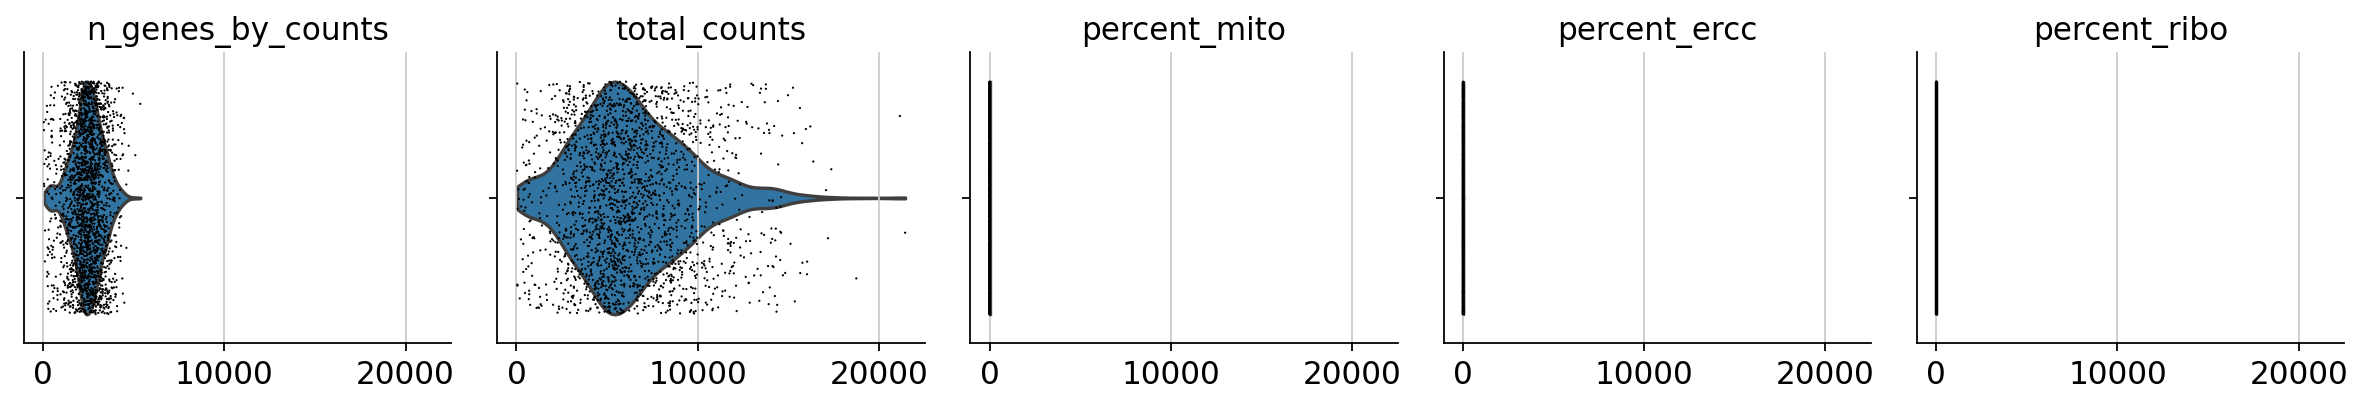

In [15]:
mito_genes = adata.var_names.str.startswith('mt-')
ercc_genes = adata.var_names.str.startswith('ERCC-')
ribo_genes = adata.var_names.str.startswith(('Rpl', 'Rps'))
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['percent_ercc'] = np.sum(adata[:, ercc_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['percent_ribo'] = np.sum(adata[:, ribo_genes].X, axis=1) / np.sum(adata.X, axis=1)

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'percent_mito', 'percent_ercc', 'percent_ribo'], jitter=0.4, multi_panel=True)

<AxesSubplot:xlabel='total_counts', ylabel='n_genes_by_counts'>

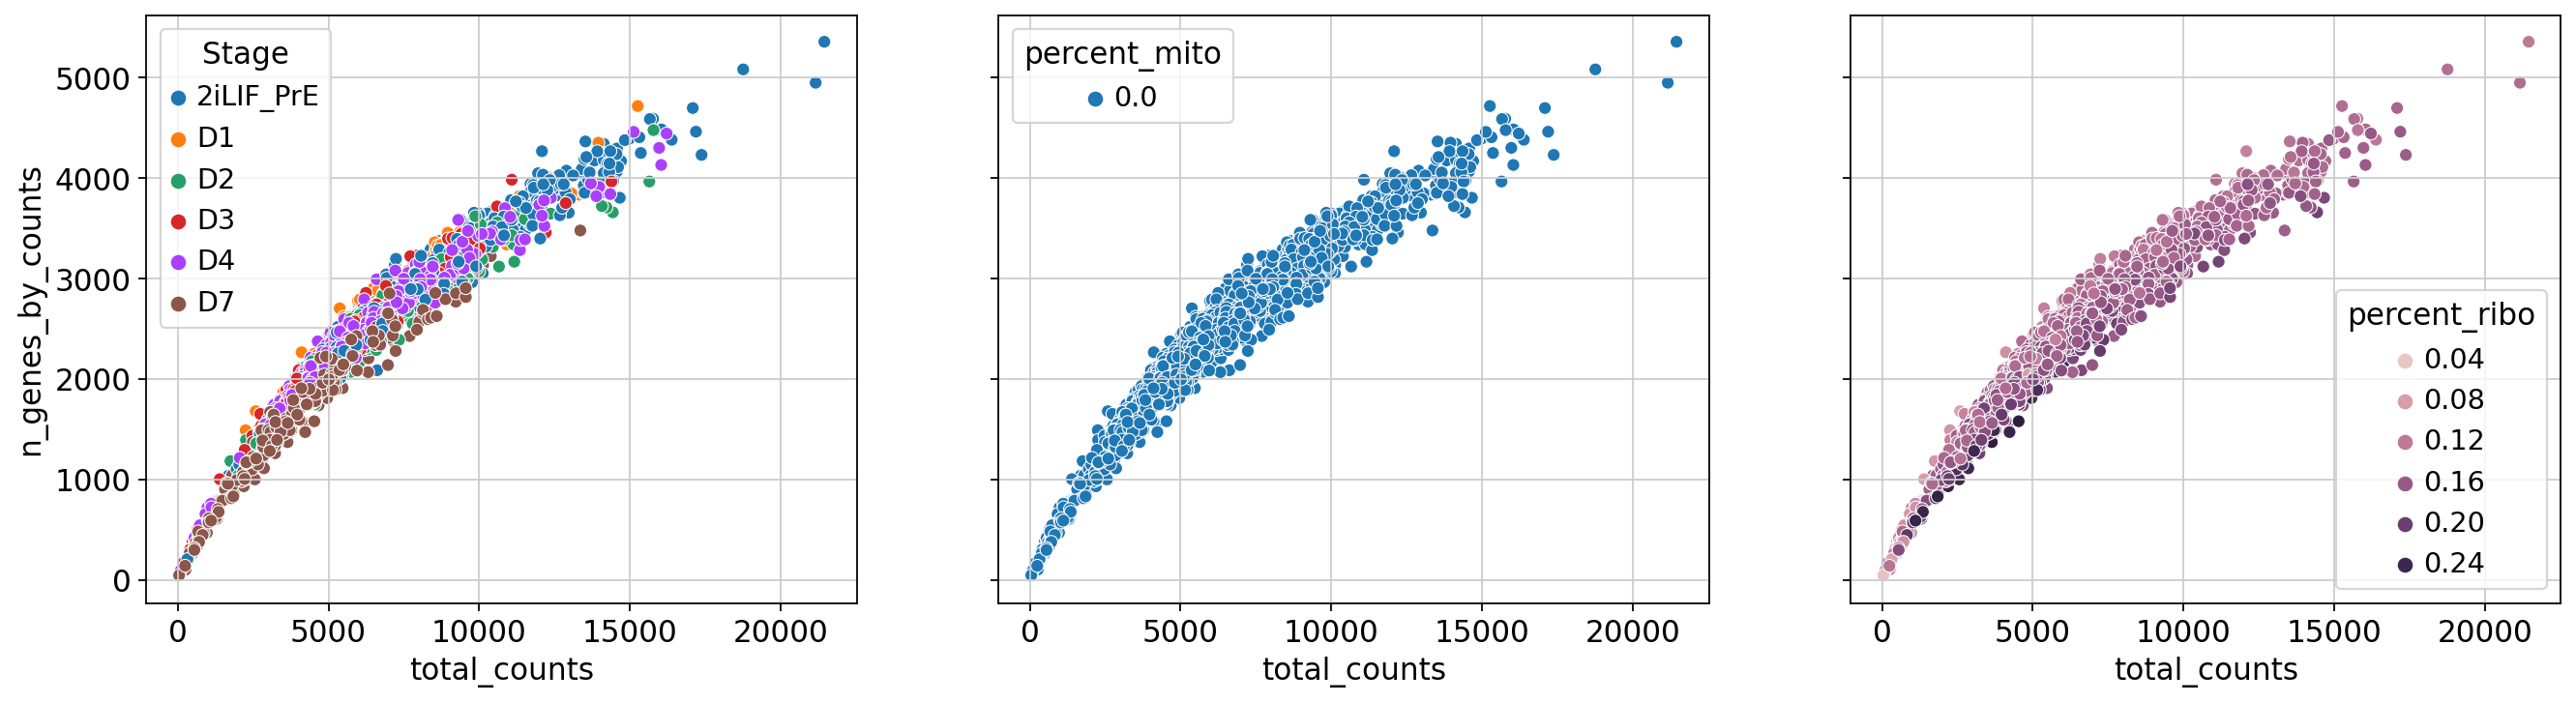

In [16]:
fig, ax = plt.subplots(1,3, figsize=(20, 5), sharey=True)
sns.scatterplot(x='total_counts', y='n_genes_by_counts', ax=ax[0], data=adata.obs, hue='Stage')
sns.scatterplot(x='total_counts', y='n_genes_by_counts', ax=ax[1], hue='percent_mito', data=adata.obs)
sns.scatterplot(x='total_counts', y='n_genes_by_counts', ax=ax[2], hue='percent_ribo', data=adata.obs)

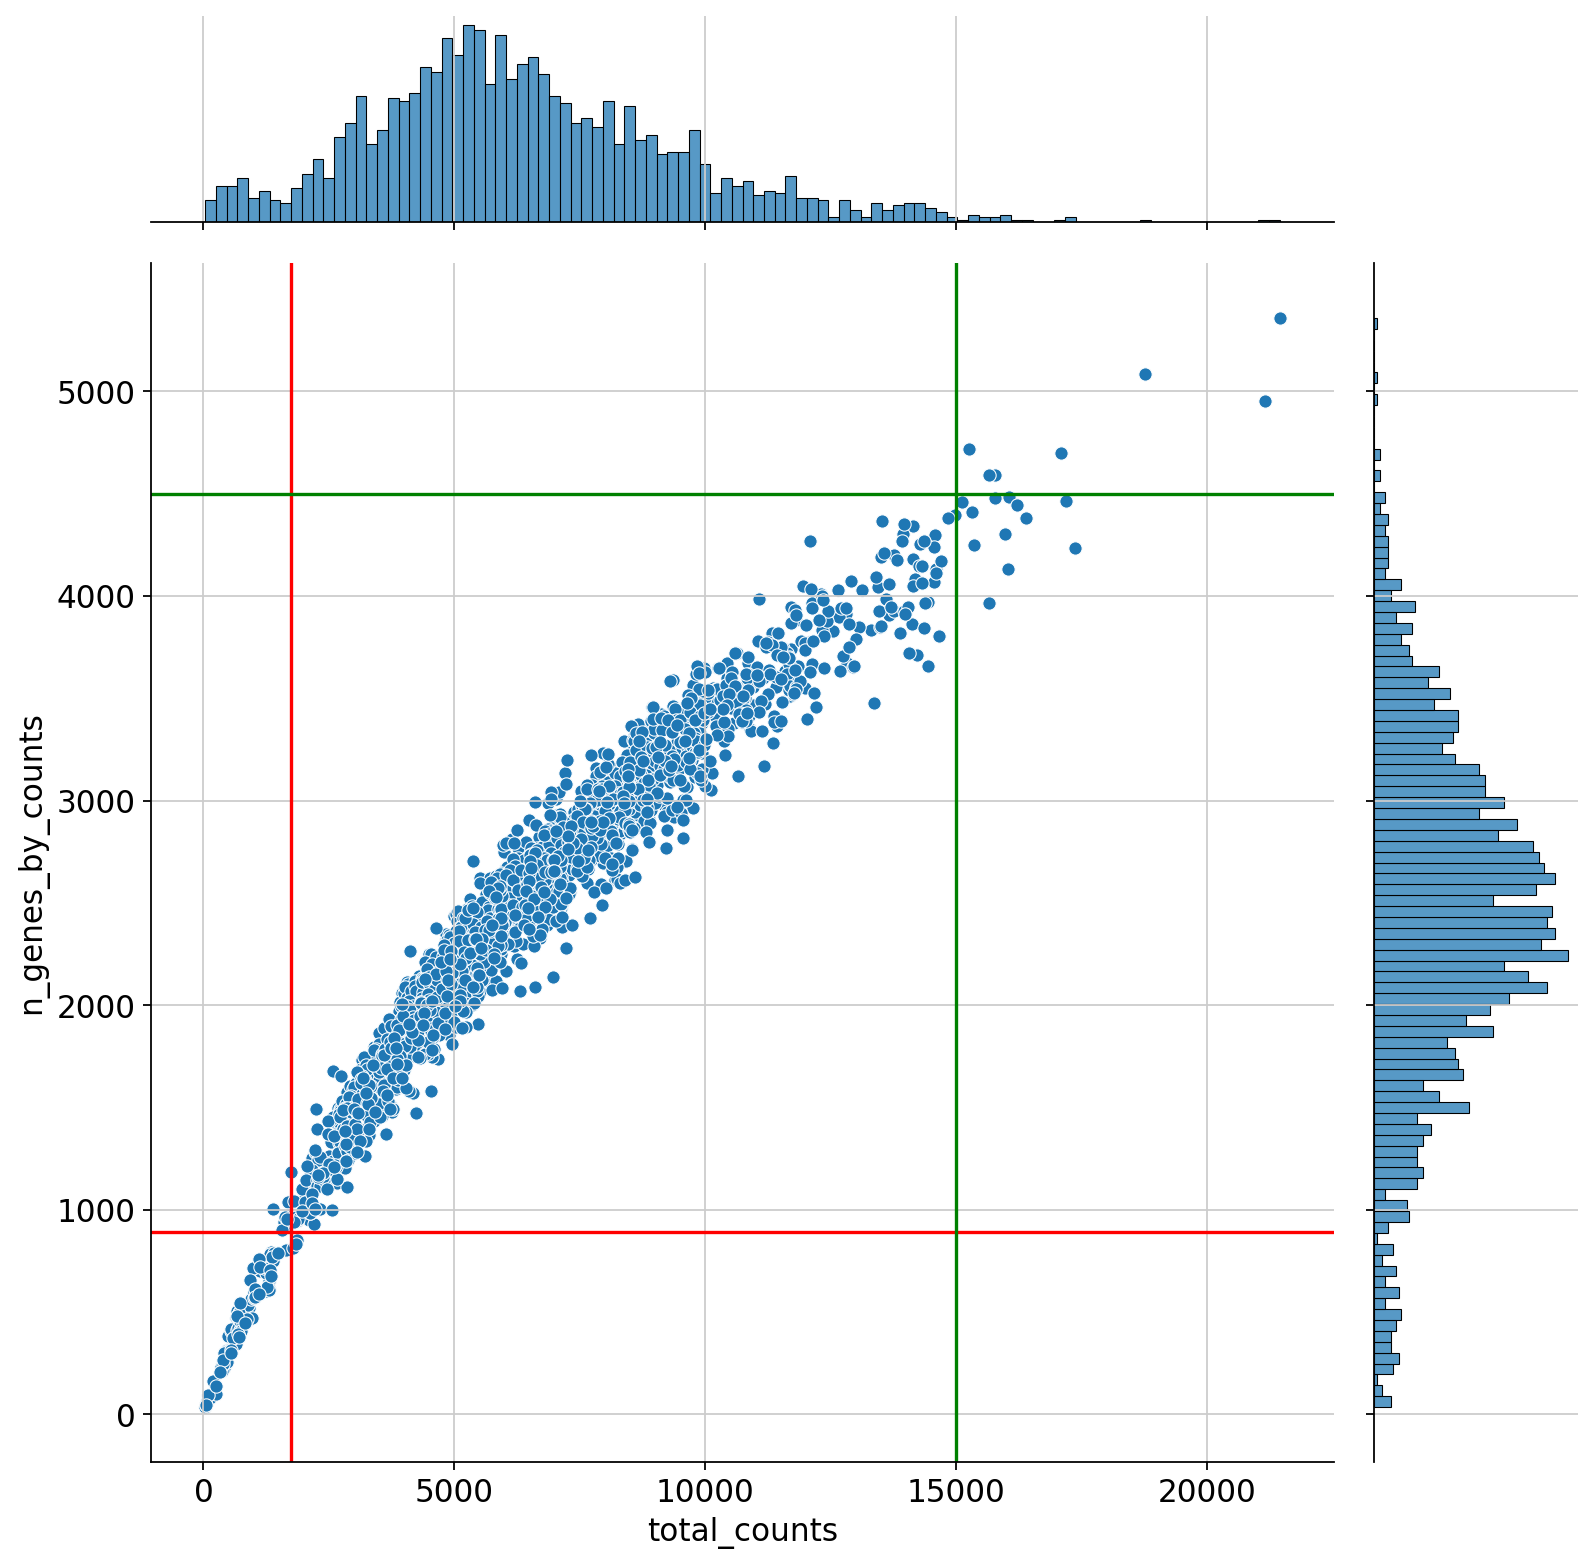

In [17]:
p = sns.jointplot(x='total_counts', y='n_genes_by_counts', data=adata.obs, marginal_kws=dict(bins=100), height=10)
# min
p.ax_joint.axvline(x=1750, color='red')
p.ax_joint.axhline(y=890, color='red')

# max
p.ax_joint.axvline(x=15000, color='green')
p.ax_joint.axhline(y=4500, color='green')

In [18]:
print(f'Before filtering: {adata.shape}')

# Remove ERCC genes
print(f'Removing {np.sum(ercc_genes)} ERCC')
not_ercc_genes = ~np.array(adata.var_names.str.startswith('ERCC-'))
adata = adata[:, not_ercc_genes]

sc.pp.filter_cells(adata, min_genes=890)
sc.pp.filter_cells(adata, min_counts=1750)
sc.pp.filter_cells(adata, max_counts=15000)
sc.pp.filter_cells(adata, max_genes=4500)

sc.pp.filter_genes(adata, min_cells=3)
print(f'After filtering: {adata.shape}')

Before filtering: (2148, 34016)
Removing 92 ERCC


/opt/conda/envs/scanpy-1.5.1/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


filtered out 92 cells that have less than 890 genes expressed


Trying to set attribute `.obs` of view, copying.


filtered out 10 cells that have less than 1750 counts
filtered out 18 cells that have more than 15000 counts
filtered out 16155 genes that are detected in less than 3 cells
After filtering: (2028, 17769)


/opt/conda/envs/scanpy-1.5.1/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/envs/scanpy-1.5.1/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/envs/scanpy-1.5.1/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/envs/scanpy-1.5.1/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/envs/scanpy-1.5.1/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_va

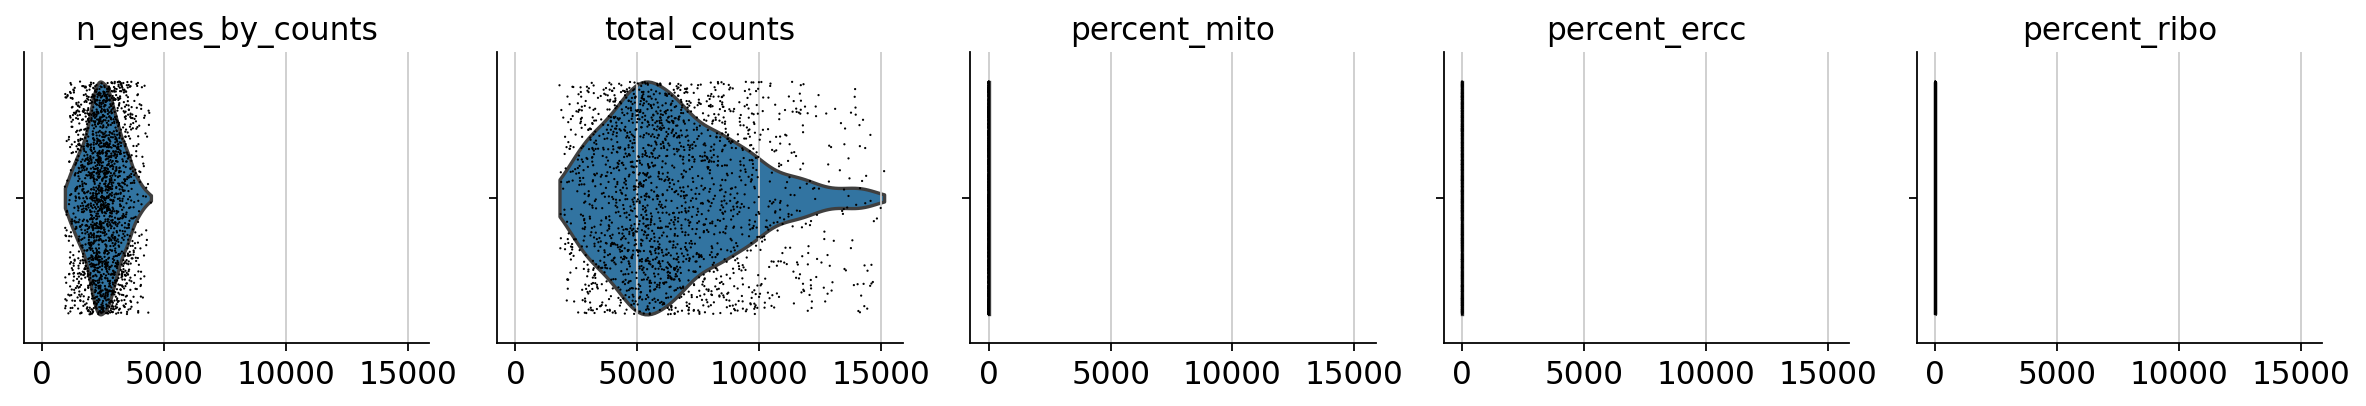

In [19]:
mito_genes = adata.var_names.str.startswith('mt-')
ercc_genes = adata.var_names.str.startswith('ERCC-')
ribo_genes = adata.var_names.str.startswith(('Rpl', 'Rps'))
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['percent_ercc'] = np.sum(adata[:, ercc_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['percent_ribo'] = np.sum(adata[:, ribo_genes].X, axis=1) / np.sum(adata.X, axis=1)

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'percent_mito', 'percent_ercc', 'percent_ribo'], jitter=0.4, multi_panel=True)

## Normalize

In [20]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


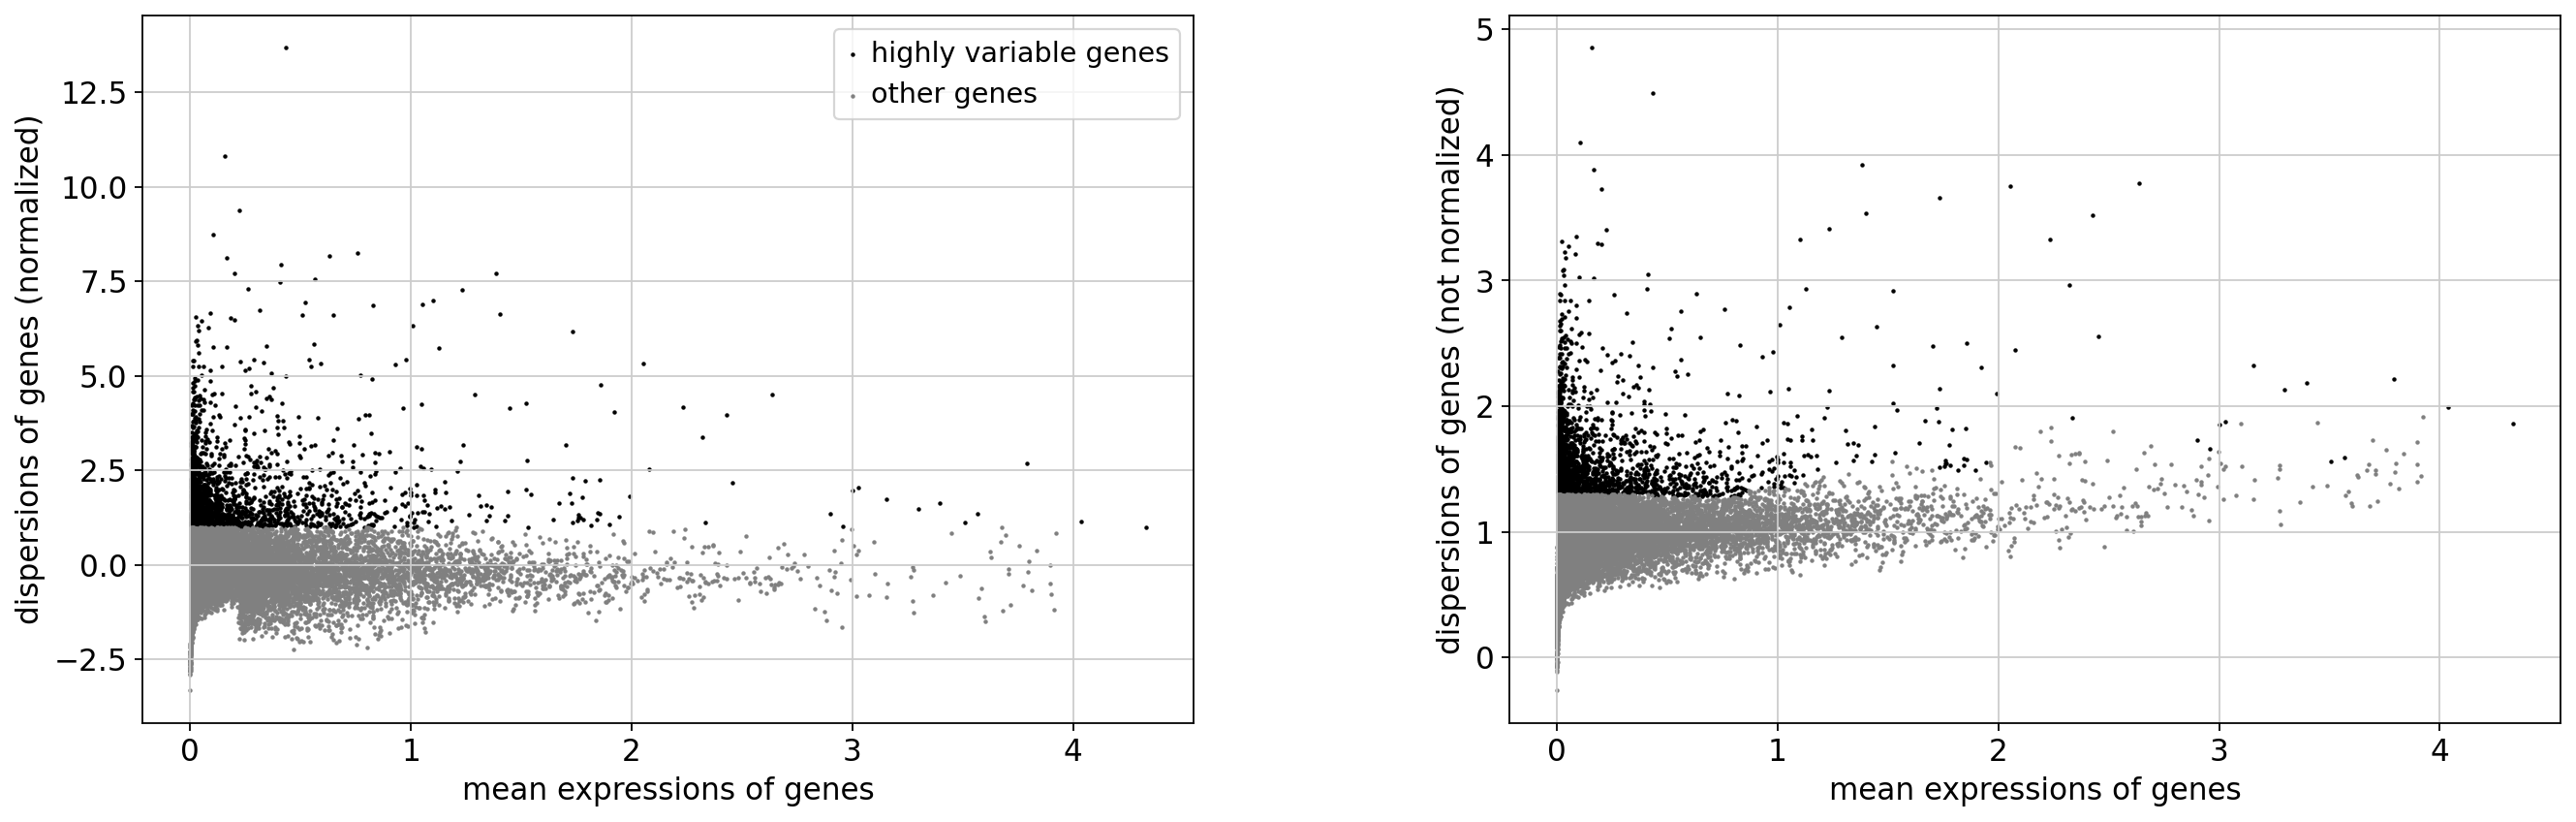

In [21]:
# Highly variable genes
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
sc.pl.highly_variable_genes(adata)
# adata = adata[:, adata.var.highly_variable]
# adata.var[adata.var.highly_variable].shape

In [22]:
sc.pp.scale(adata, max_value=5)

## Visualization

computing PCA
    on highly variable genes
    with n_comps=50


/opt/conda/envs/scanpy-1.5.1/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


    finished (0:00:00)


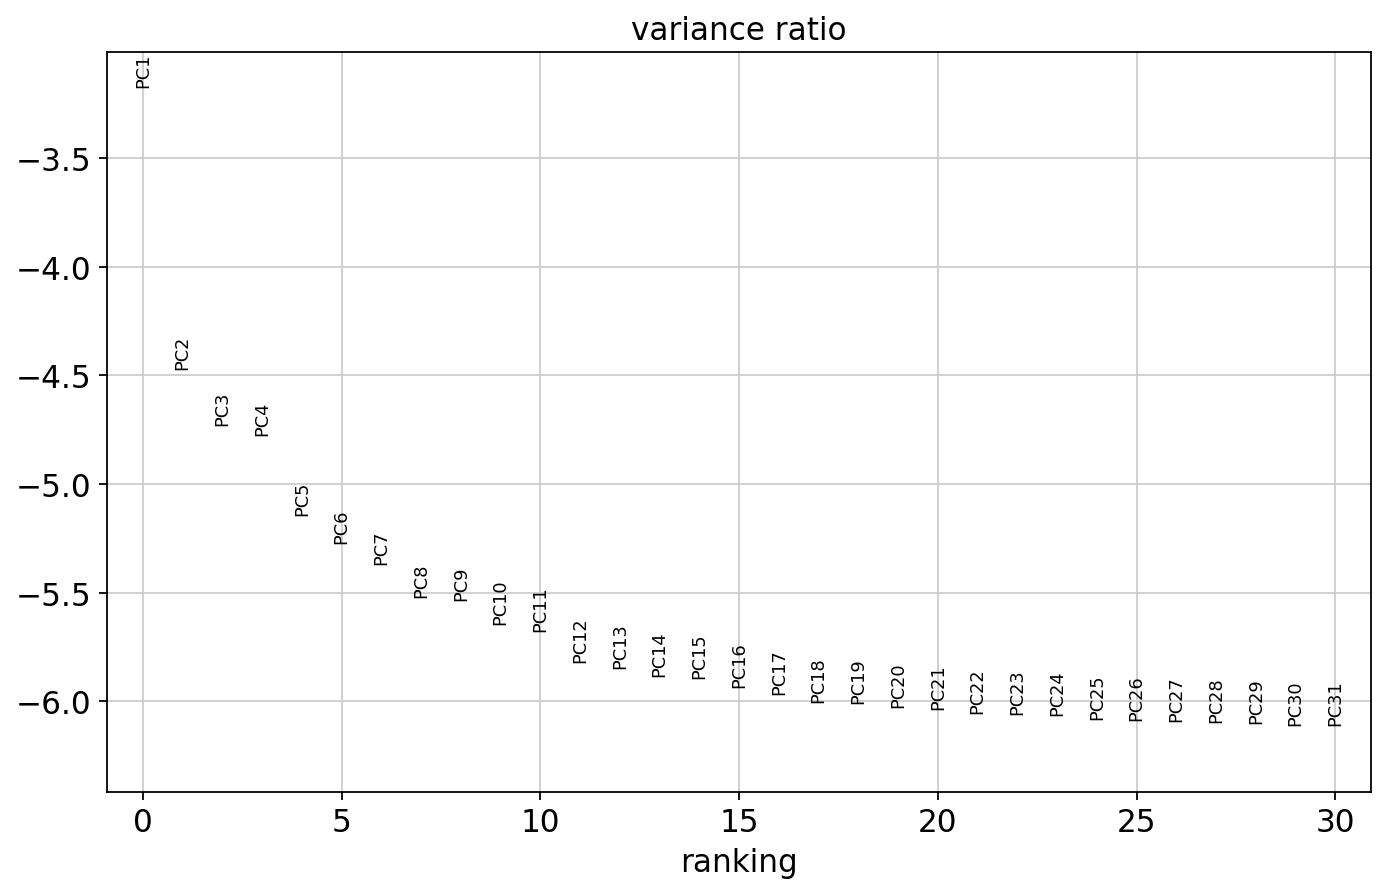

In [23]:
sc.tl.pca(adata, svd_solver='arpack', random_state=random_seed)
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
sc.pp.neighbors(adata, n_pcs=15, random_state=random_seed)
sc.tl.umap(adata, random_state=random_seed)
sc.tl.louvain(adata, resolution=0.8, random_state=random_seed)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


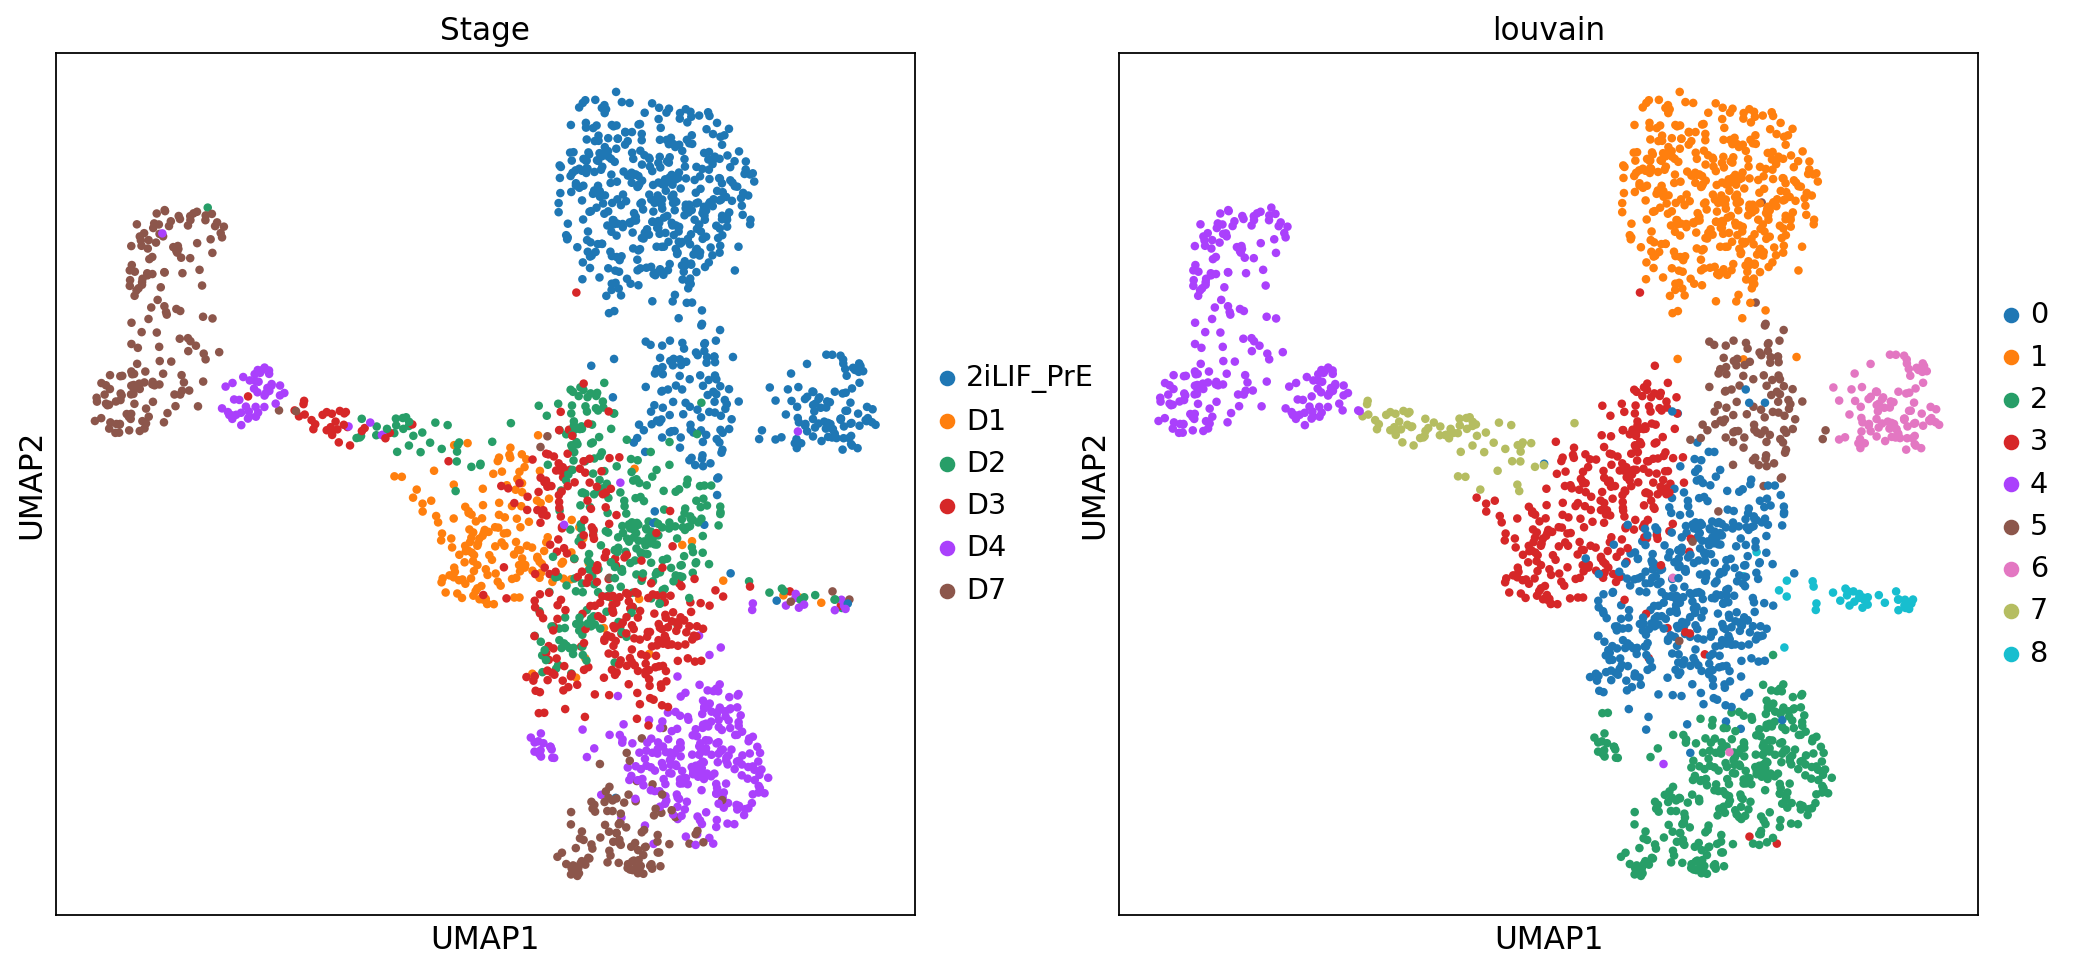

In [25]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata, color=['Stage', 'louvain'])

## Markers

In [26]:
sc.tl.rank_genes_groups(adata, groupby='louvain')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


In [27]:
m = get_filtered_markers(adata, groupby='louvain', log_th=1, p_th=0.05)

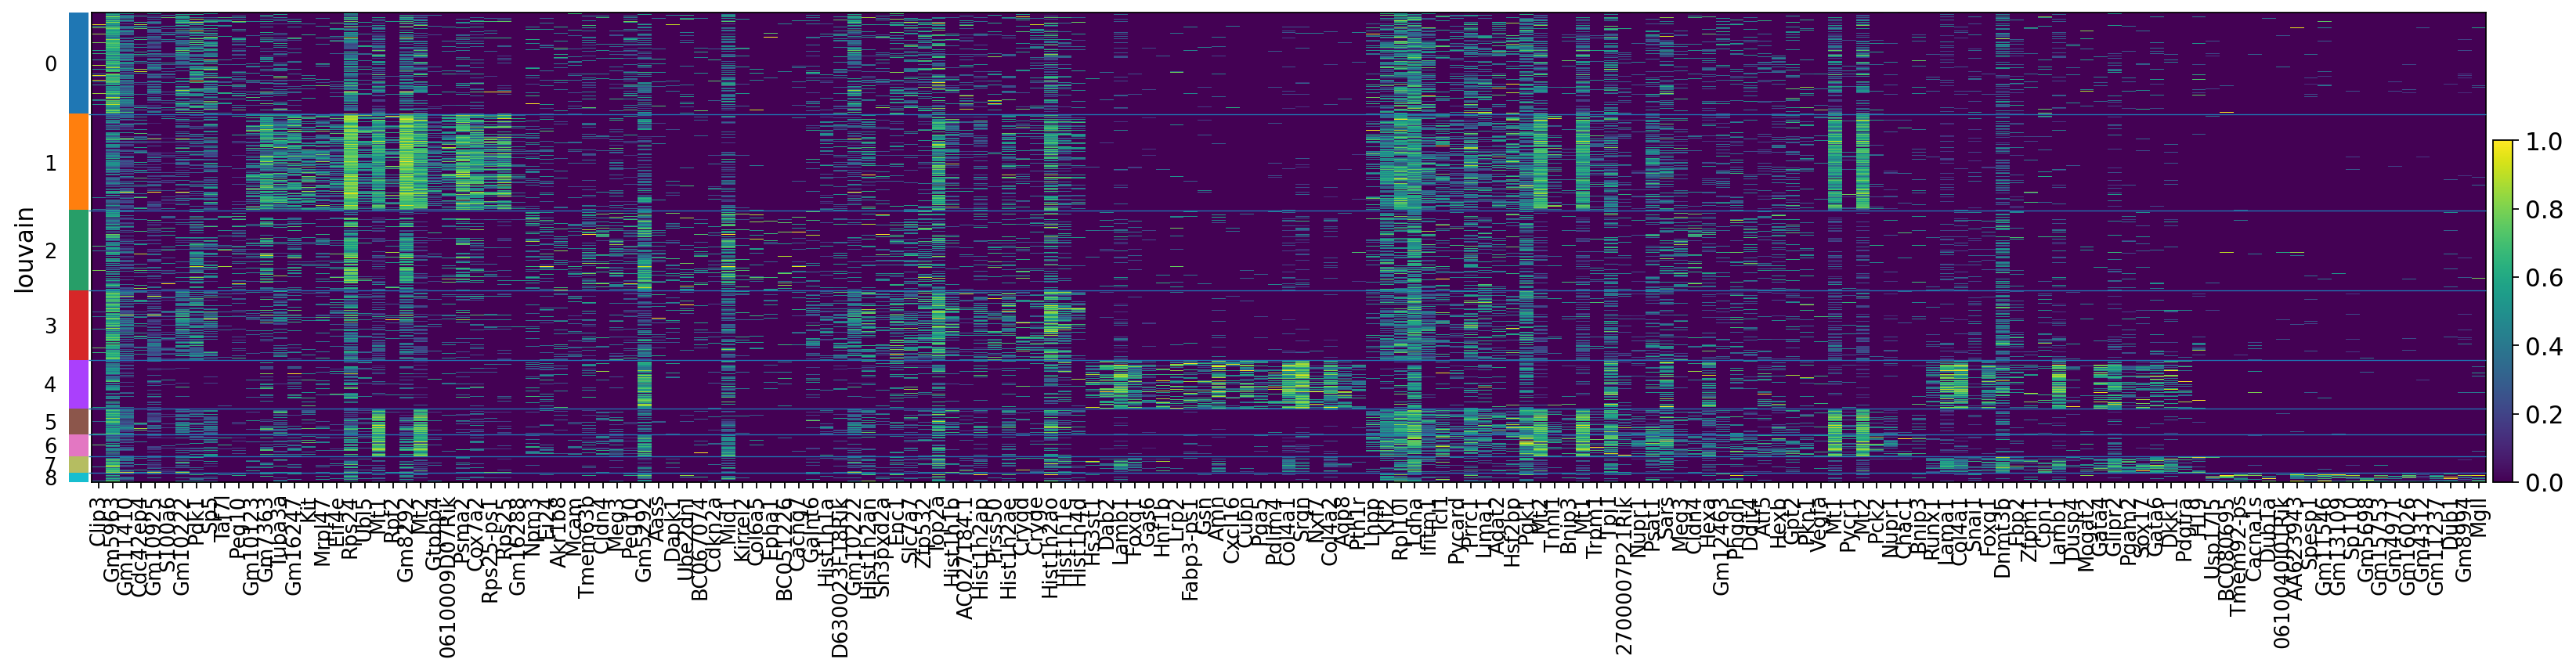

GridSpec(2, 4, height_ratios=[0, 5], width_ratios=[0.2, 24.8, 0, 0.2])

In [28]:
sc.pl.heatmap(adata, m.names, groupby='louvain', standard_scale='var', show_gene_labels=True, figsize=[25, 5])

# Trajectory inference

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


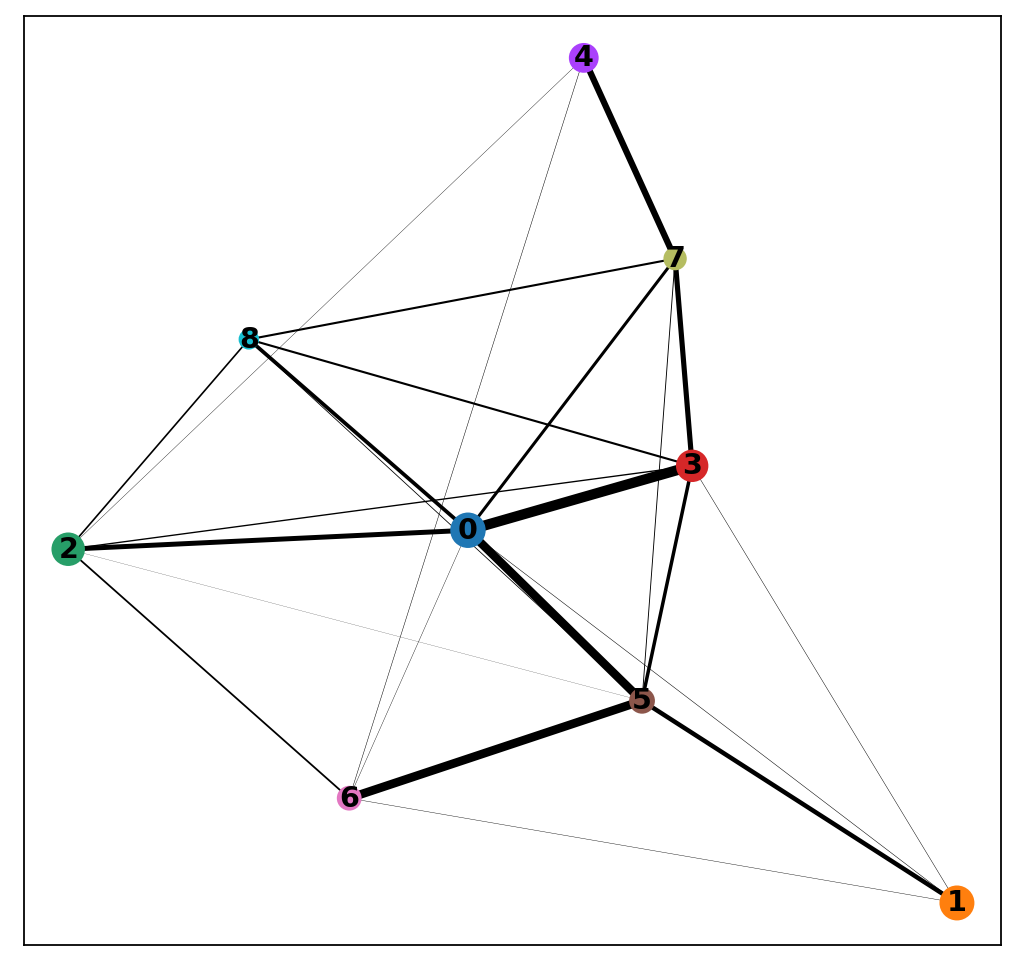

--> added 'pos', the PAGA positions (adata.uns['paga'])
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:14)


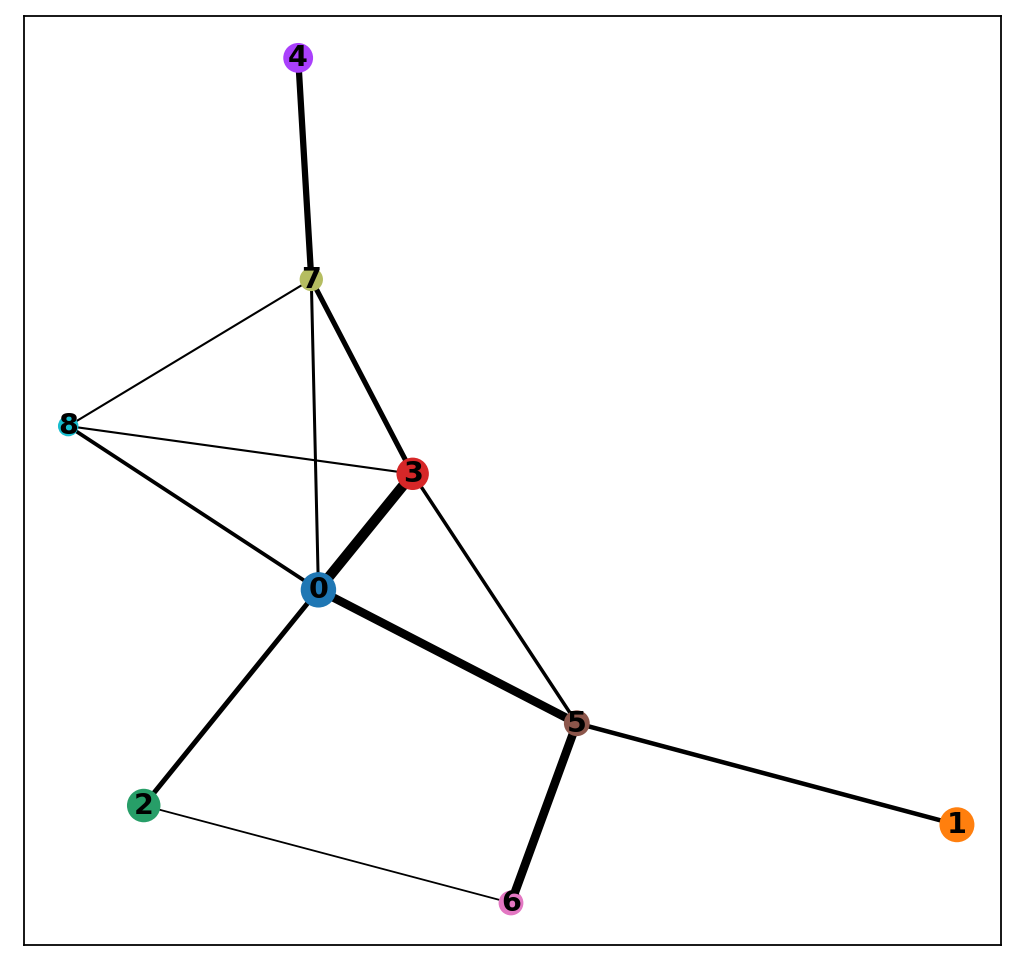

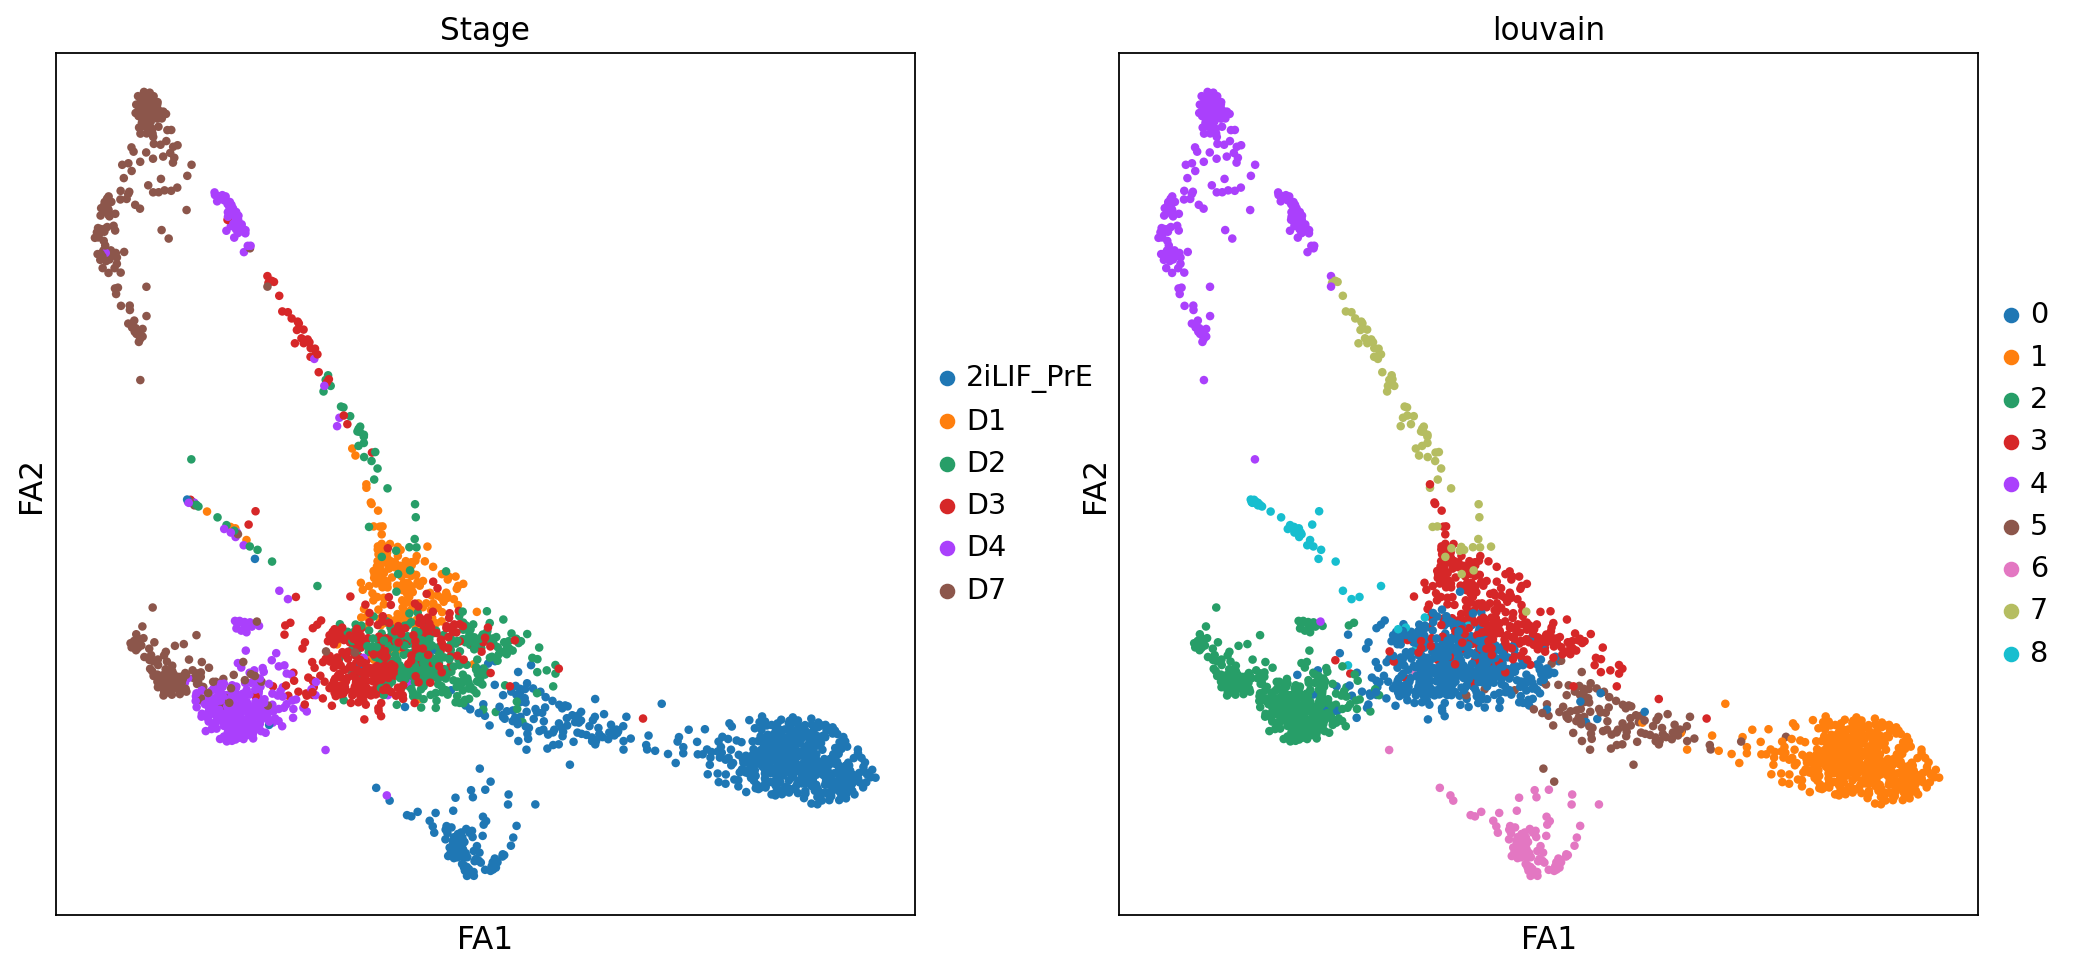

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99446744 0.98414695 0.97542673 0.9697013  0.9683301
     0.96263266 0.9478609  0.92224985 0.9169017  0.9015281  0.89846367
     0.88714504 0.88423145 0.87750775]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


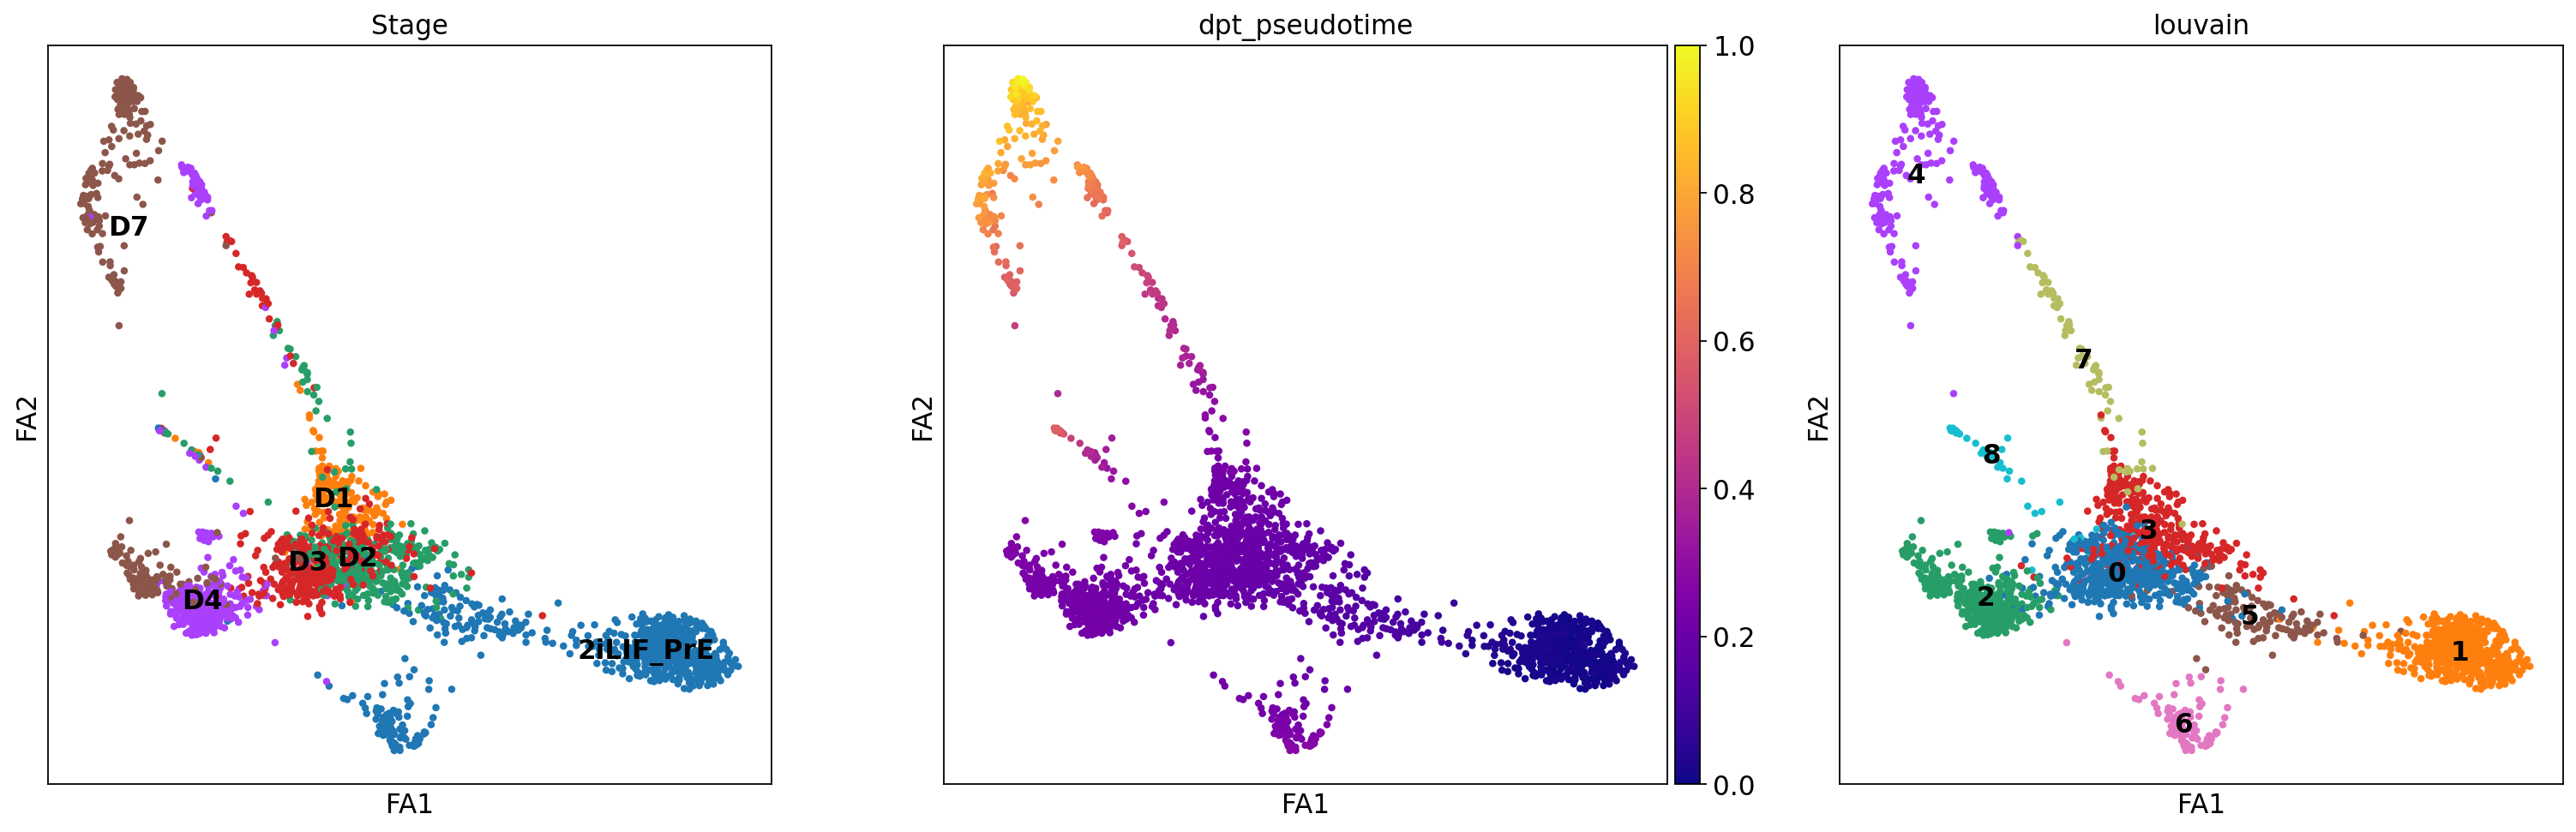

--> added 'pos', the PAGA positions (adata.uns['paga'])


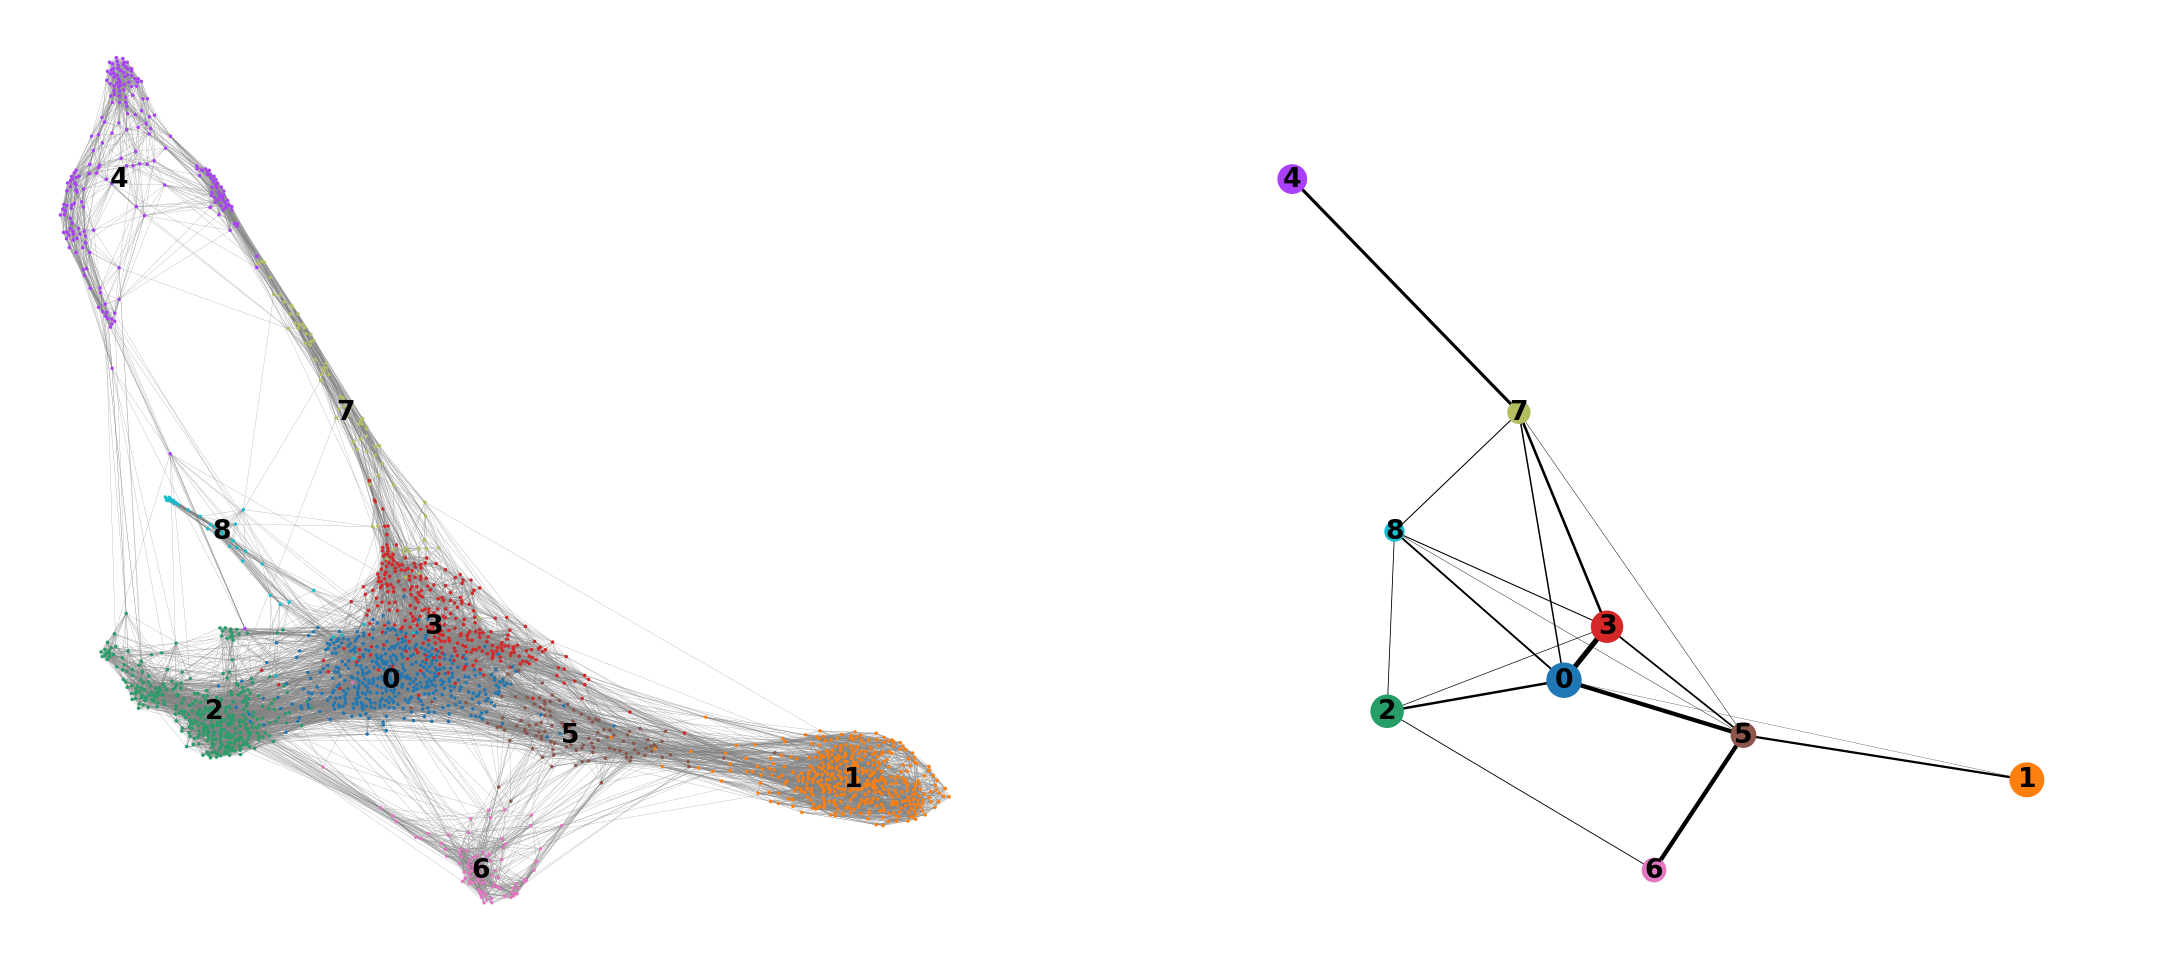

In [29]:
adata = run_paga(adata, start_cell=1, by='louvain')

## Save session

In [30]:
adata.write('../data/processed/04_dataset.h5ad')

In [31]:
adata.obs.to_csv('../data/processed/04_dataset-metadata.csv')

## Save report

In [32]:
!jupyter nbconvert --to html '04_analysis.ipynb' --output-dir="../reports"

[NbConvertApp] Converting notebook 04_analysis.ipynb to html
[NbConvertApp] Writing 5613708 bytes to ../reports/04_analysis.html


In [43]:
adata.to_df()

0610005C13Rik  0610007C21Rik  0610007L01Rik  0610007P08Rik  \
Well_ID                                                               
W1           -0.087704      -0.471216      -0.763566      -0.361599   
W3           -0.087704      -0.471216      -0.763566      -0.361599   
W4           -0.087704      -0.471216       1.452322      -0.361599   
W5           -0.087704      -0.471216       0.738652      -0.361599   
W6           -0.087704      -0.471216      -0.763566      -0.361599   
...                ...            ...            ...            ...   
W2491        -0.087704      -0.471216      -0.763566      -0.361599   
W2492        -0.087704       0.740979      -0.763566      -0.361599   
W2494        -0.087704      -0.471216       2.886730      -0.361599   
W2495        -0.087704      -0.471216      -0.763566      -0.361599   
W2496        -0.087704      -0.471216      -0.763566      -0.361599   

         0610007P14Rik  0610007P22Rik  0610009B14Rik  0610009B22Rik  \
Well_ID                                                               
W1            0.551466       1.212275      -0.047007      -0.343340   
W3            0.378728      -0.539026      -0.047007      -0.343340   
W4           -0.822234      -0.539026      -0.047007       2.240337   
W5            1.917106      -0.539026      -0.047007      -0.343340   
W6           -0.822234      -0.539026      -0.047007      -0.343340   
...                ...            ...            ...            ...   
W2491        -0.822234       2.941341      -0.047007      -0.343340   
W2492         2.238026      -0.539026      -0.047007      -0.343340   
W2494        -0.822234      -0.539026      -0.047007      -0.343340   
W2495         1.692961      -0.539026      -0.047007      -0.343340   
W2496         2.123440      -0.539026      -0.047007      -0.343340   

         0610009D07Rik  0610009E02Rik  ...  n-R5s194  n-R5s204   n-R5s56  \
Well_ID                                ...                                 
W1            1.536664      -0.069129  ... -0.038391 -0.037565 -0.044136   
W3            1.290361      -0.069129  ... -0.038391 -0.037565 -0.044136   
W4           -0.422066      -0.069129  ... -0.038391 -0.037565 -0.044136   
W5           -0.422066      -0.069129  ... -0.038391 -0.037565 -0.044136   
W6            1.359039      -0.069129  ... -0.038391 -0.037565 -0.044136   
...                ...            ...  ...       ...       ...       ...   
W2491        -0.422066      -0.069129  ... -0.038391 -0.037565 -0.044136   
W2492        -0.422066      -0.069129  ... -0.038391 -0.037565 -0.044136   
W2494        -0.422066      -0.069129  ... -0.038391 -0.037565 -0.044136   
W2495        -0.422066      -0.069129  ... -0.038391 -0.037565 -0.044136   
W2496        -0.422066       5.000000  ... -0.038391 -0.037565 -0.044136   

          n-R5s92    snoU13    snoU54   snoU89    snoU97    snoZ39    snoZ40  
Well_ID                                                                       
W1      -0.070744 -0.097752 -0.044057 -0.19334 -0.054233 -0.092064 -0.062957  
W3      -0.070744 -0.097752 -0.044057 -0.19334 -0.054233 -0.092064 -0.062957  
W4      -0.070744 -0.097752 -0.044057 -0.19334 -0.054233 -0.092064 -0.062957  
W5      -0.070744 -0.097752 -0.044057 -0.19334 -0.054233 -0.092064 -0.062957  
W6      -0.070744 -0.097752 -0.044057 -0.19334 -0.054233 -0.092064 -0.062957  
...           ...       ...       ...      ...       ...       ...       ...  
W2491   -0.070744 -0.097752 -0.044057 -0.19334 -0.054233 -0.092064 -0.062957  
W2492   -0.070744 -0.097752 -0.044057 -0.19334 -0.054233 -0.092064 -0.062957  
W2494   -0.070744 -0.097752 -0.044057 -0.19334 -0.054233 -0.092064 -0.062957  
W2495   -0.070744 -0.097752 -0.044057 -0.19334 -0.054233 -0.092064 -0.062957  
W2496   -0.070744 -0.097752 -0.044057 -0.19334 -0.054233 -0.092064 -0.062957  

[2028 rows x 17769 columns]